In [1]:
import sys
import os
sys.path.append(os.path.dirname(os.getcwd()))

In [2]:
from bart_playground import *

In [3]:
notebook = "real3_CalHousing"

In [4]:
import numpy as np

from sklearn.datasets import fetch_california_housing

data = fetch_california_housing(as_frame=True)

X = data.data
y = data.target

In [5]:
X = X.values.astype(float)
y = np.array(y).reshape(-1)

In [6]:
ndpost = 50000
nskip = 0
n_trees = 100

In [ ]:
from experiment import run_parallel_experiments

# Run 5 parallel experiments with different train-test splits
results = run_parallel_experiments(X, y, ndpost, nskip, n_trees, notebook, n_runs=5, n_jobs=-2)

## Default
### KPSS test

In [8]:
from diagnosis import segmented_kpss_test

=== Default BART Analysis ===

--- Run 0 ---
Sigma convergence analysis:


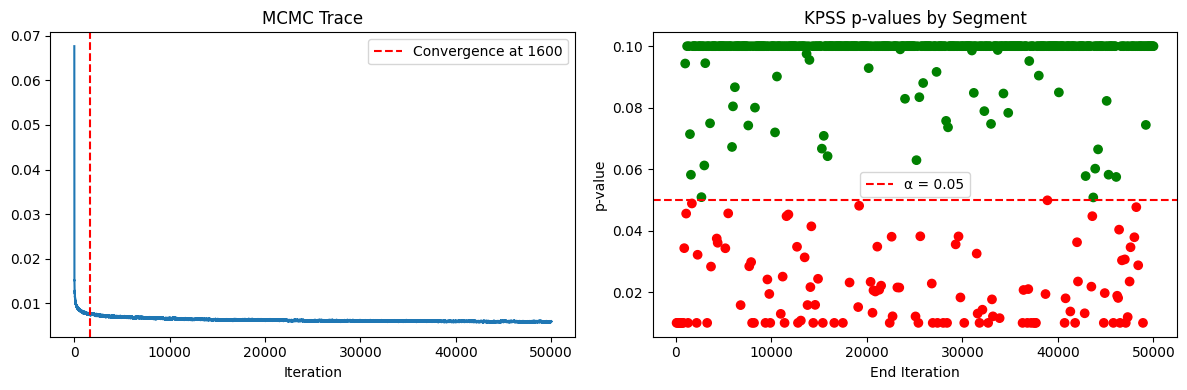

Chain converged: True
Convergence at iteration: 1600
Convergence rate: 76.40%

RMSE convergence analysis:


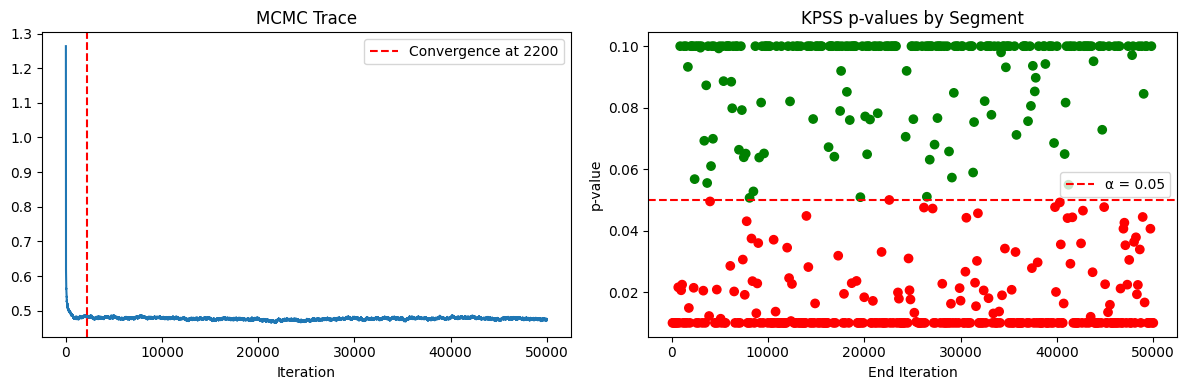

Chain converged: True
Convergence at iteration: 2200
Convergence rate: 43.20%

--- Run 1 ---
Sigma convergence analysis:


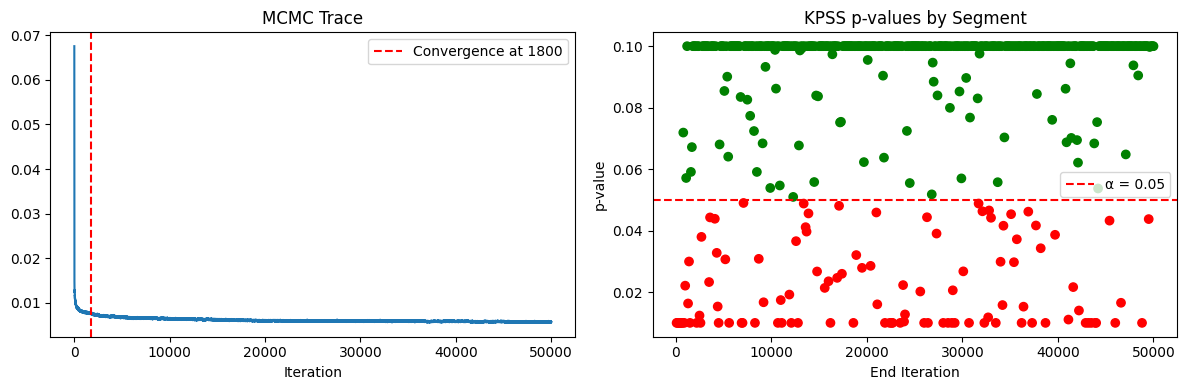

Chain converged: True
Convergence at iteration: 1800
Convergence rate: 78.40%

RMSE convergence analysis:


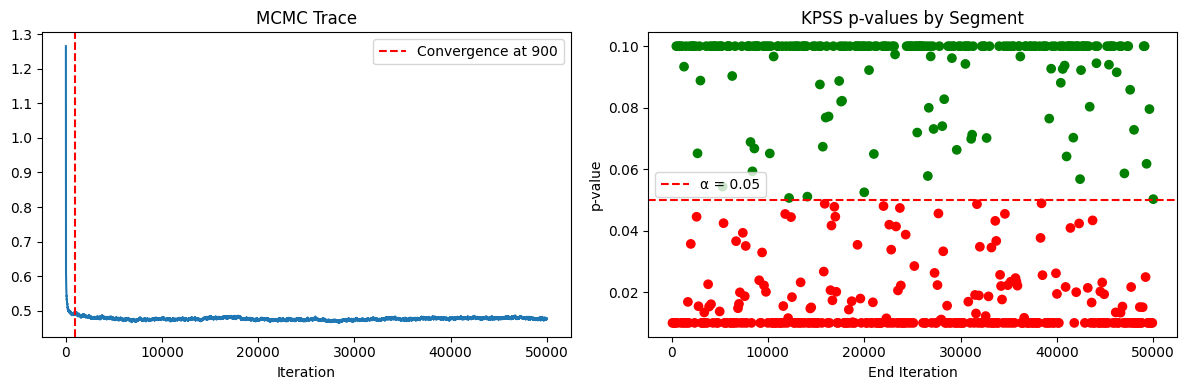

Chain converged: True
Convergence at iteration: 900
Convergence rate: 43.40%

--- Run 2 ---
Sigma convergence analysis:


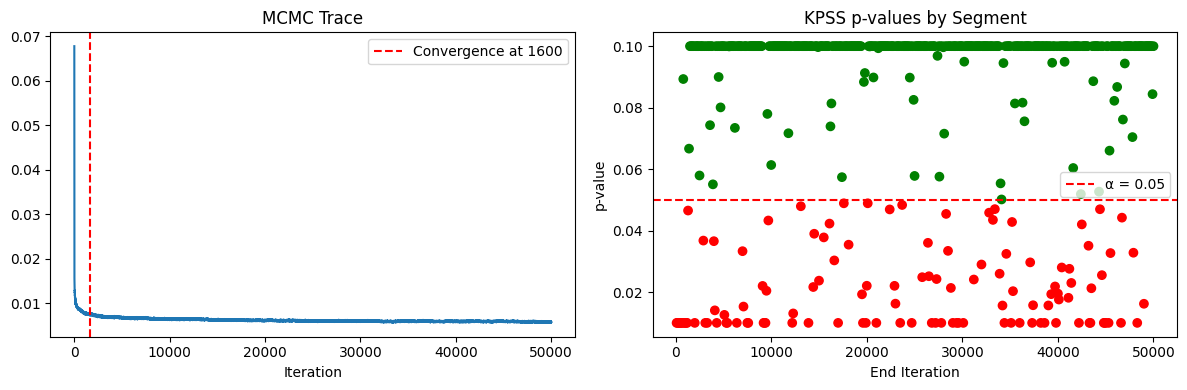

Chain converged: True
Convergence at iteration: 1600
Convergence rate: 76.40%

RMSE convergence analysis:


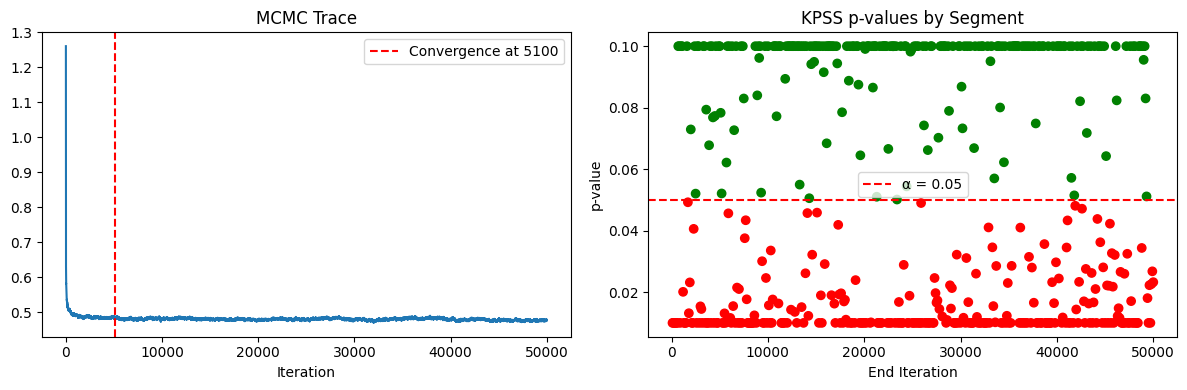

Chain converged: True
Convergence at iteration: 5100
Convergence rate: 44.80%

--- Run 3 ---
Sigma convergence analysis:


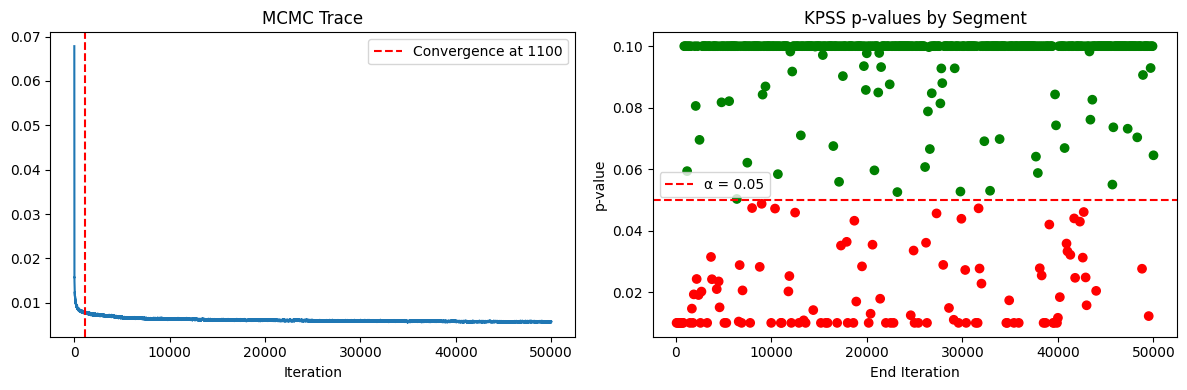

Chain converged: True
Convergence at iteration: 1100
Convergence rate: 78.20%

RMSE convergence analysis:


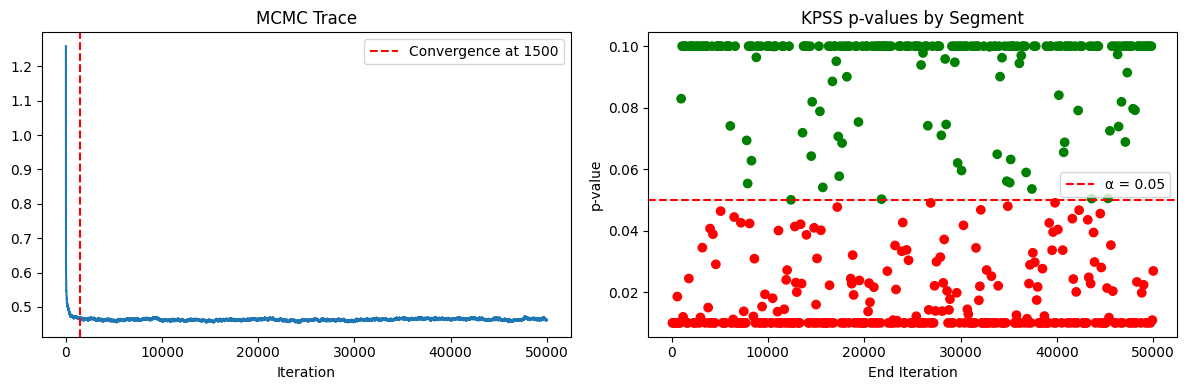

Chain converged: True
Convergence at iteration: 1500
Convergence rate: 42.40%

--- Run 4 ---
Sigma convergence analysis:


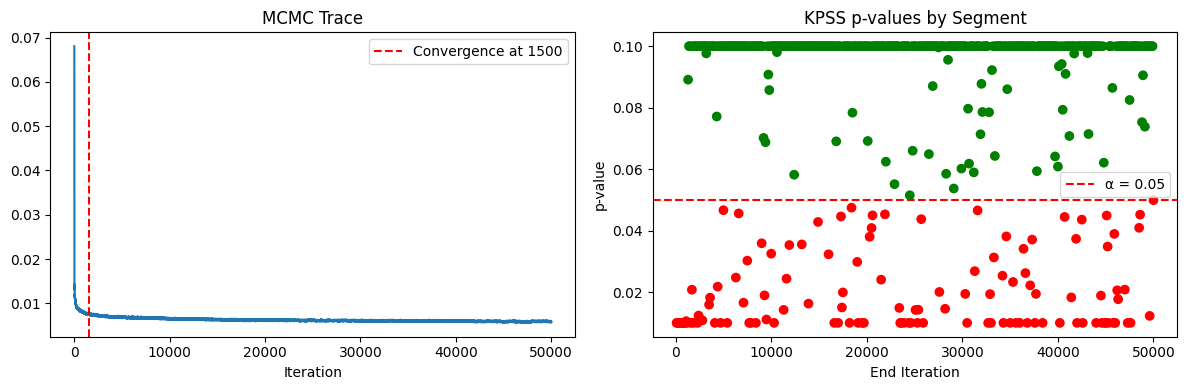

Chain converged: True
Convergence at iteration: 1500
Convergence rate: 75.40%

RMSE convergence analysis:


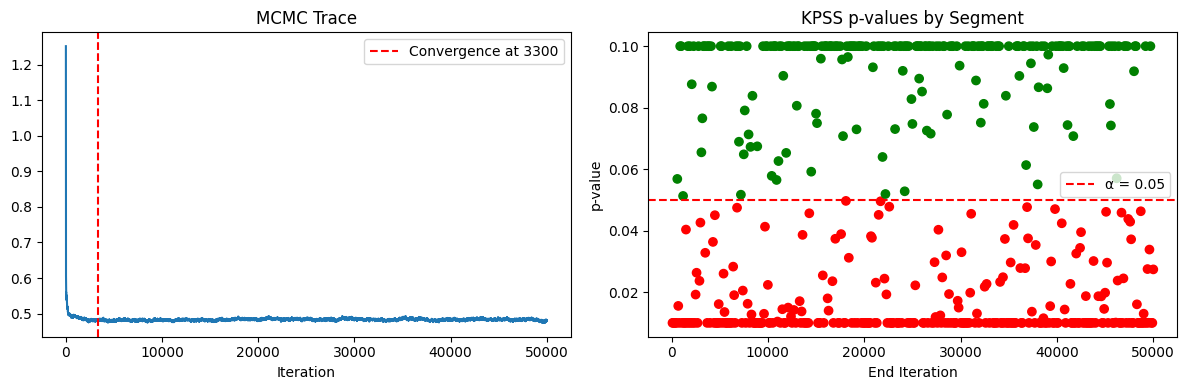

Chain converged: True
Convergence at iteration: 3300
Convergence rate: 43.20%


In [9]:
# Analyze each run's results and collect statistics
n_runs = 5

# Collect convergence statistics
default_sigma_convergence = []
default_rmse_convergence = []
default_sigma_rates = []
default_rmse_rates = []

# Analyze Default BART results
print("=== Default BART Analysis ===")
for run_id in range(n_runs):
    print(f"\n--- Run {run_id} ---")
    
    # Load sigmas and rmses for this run
    sigmas = np.load(f'store/{notebook}_sigmas_default_run{run_id}.npy')
    rmses = np.load(f'store/{notebook}_rmses_default_run{run_id}.npy')
    
    print(f"Sigma convergence analysis:")
    convergence_result = segmented_kpss_test(sigmas, segment_length=100)
    print(f"Chain converged: {convergence_result['converged']}")
    if convergence_result['converged']:
        print(f"Convergence at iteration: {convergence_result['convergence_iteration']}")
        default_sigma_convergence.append(convergence_result['convergence_iteration'])
    print(f"Convergence rate: {convergence_result['convergence_rate']:.2%}")
    default_sigma_rates.append(convergence_result['convergence_rate'])
    
    print(f"\nRMSE convergence analysis:")
    convergence_result = segmented_kpss_test(rmses, segment_length=100)
    print(f"Chain converged: {convergence_result['converged']}")
    if convergence_result['converged']:
        print(f"Convergence at iteration: {convergence_result['convergence_iteration']}")
        default_rmse_convergence.append(convergence_result['convergence_iteration'])
    print(f"Convergence rate: {convergence_result['convergence_rate']:.2%}")
    default_rmse_rates.append(convergence_result['convergence_rate'])

In [10]:
# Print summary statistics for Default BART
print("\n=== Default BART Summary ===")
if default_sigma_convergence:
    print(f"Sigma - Average convergence iteration: {np.mean(default_sigma_convergence):.0f}")
else:
    print("Sigma - No convergence detected")
print(f"Sigma - Average convergence rate: {np.mean(default_sigma_rates):.2%}")

if default_rmse_convergence:
    print(f"RMSE - Average convergence iteration: {np.mean(default_rmse_convergence):.0f}")
else:
    print("RMSE - No convergence detected")
print(f"RMSE - Average convergence rate: {np.mean(default_rmse_rates):.2%}")


=== Default BART Summary ===
Sigma - Average convergence iteration: 1520
Sigma - Average convergence rate: 76.96%
RMSE - Average convergence iteration: 2600
RMSE - Average convergence rate: 43.40%


### ESS

In [11]:
# Add logging configuration before importing arviz
import logging
logging.getLogger('arviz.preview').setLevel(logging.WARNING)
import arviz as az

In [12]:
# Analyze each run's results
n_runs = 5

# Analyze Default BART results
print("=== Default BART Analysis ===")
for run_id in range(n_runs):
    print(f"\n--- Run {run_id} ---")
    
    # Load sigmas and rmses for this run
    sigmas = np.load(f'store/{notebook}_sigmas_default_run{run_id}.npy')
    rmses = np.load(f'store/{notebook}_rmses_default_run{run_id}.npy')

    print(f"Sigma ess value: {az.ess(sigmas[10000:].reshape(1, -1), relative=True).item():.6f}")
    print(f"RMSE ess value: {az.ess(rmses[10000:].reshape(1, -1), relative=True).item():.6f}")

=== Default BART Analysis ===

--- Run 0 ---
Sigma ess value: 0.000036
RMSE ess value: 0.000128

--- Run 1 ---
Sigma ess value: 0.000040
RMSE ess value: 0.000191

--- Run 2 ---
Sigma ess value: 0.000039
RMSE ess value: 0.000334

--- Run 3 ---
Sigma ess value: 0.000037
RMSE ess value: 0.000072

--- Run 4 ---
Sigma ess value: 0.000038
RMSE ess value: 0.001598


### Autocorrelation

In [13]:
from diagnosis import plot_autocorrelation

=== Default BART Analysis ===

--- Run 0 ---
Sigma autocorrelation plot:


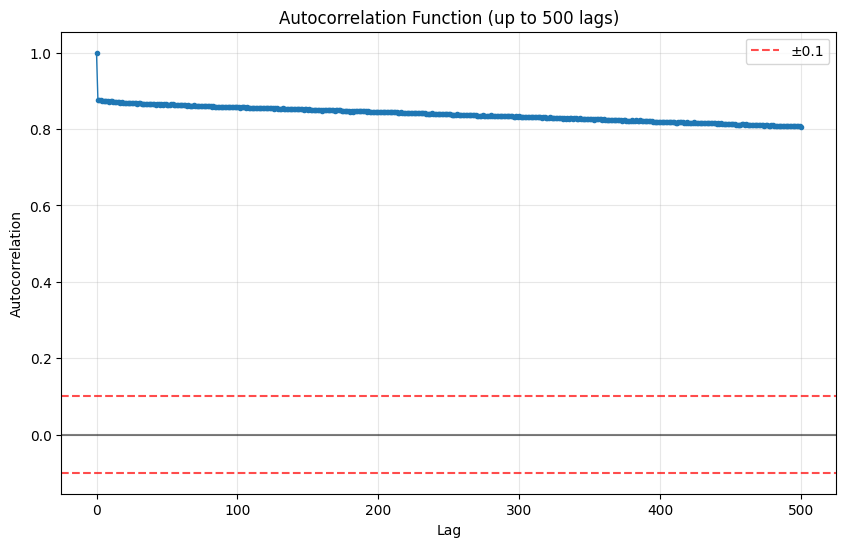

RMSE autocorrelation plot:


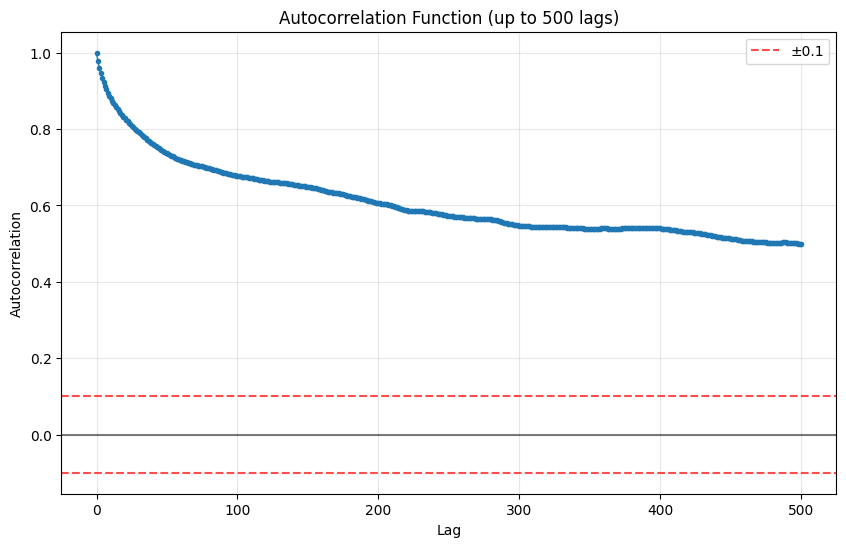


--- Run 1 ---
Sigma autocorrelation plot:


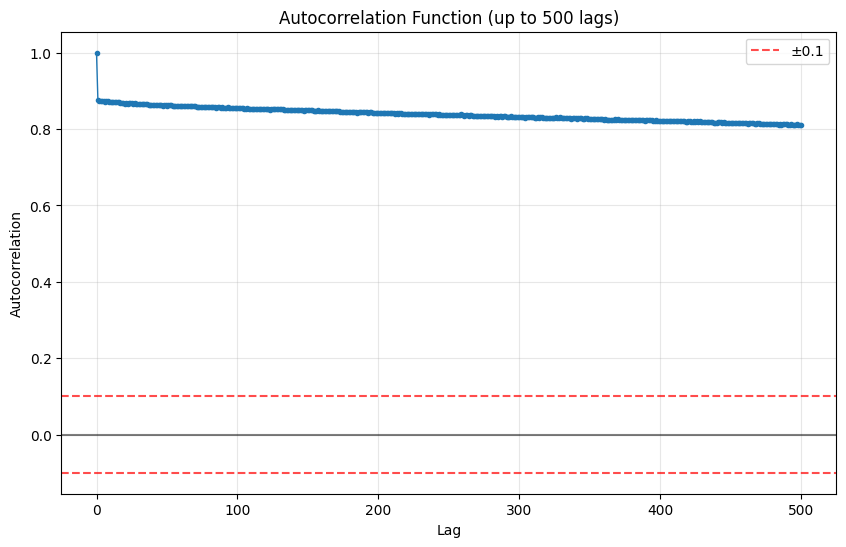

RMSE autocorrelation plot:


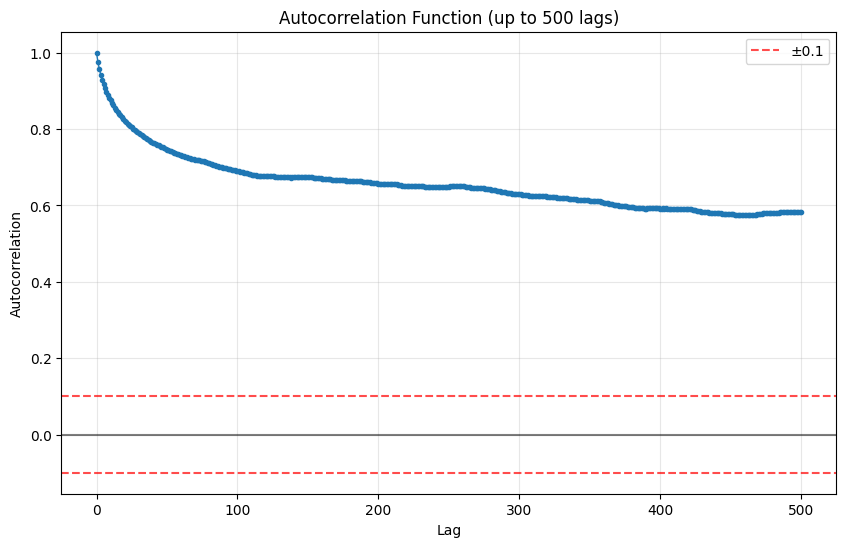


--- Run 2 ---
Sigma autocorrelation plot:


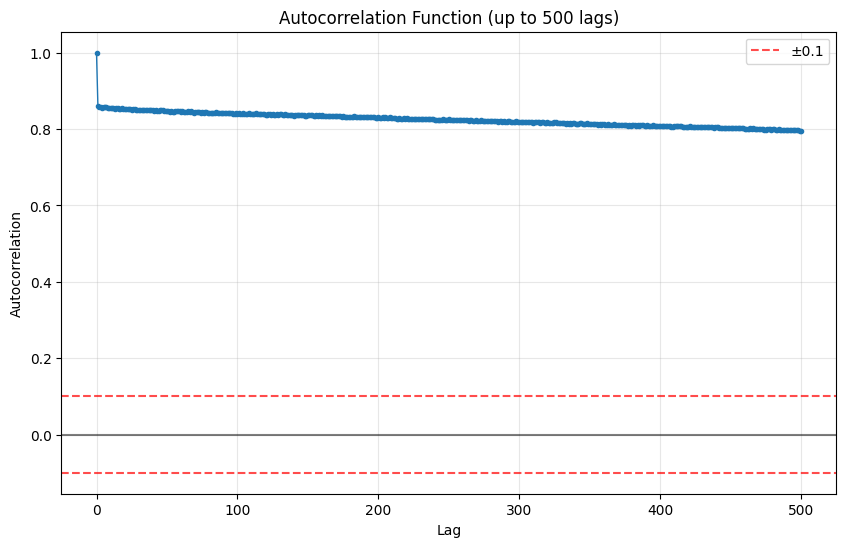

RMSE autocorrelation plot:


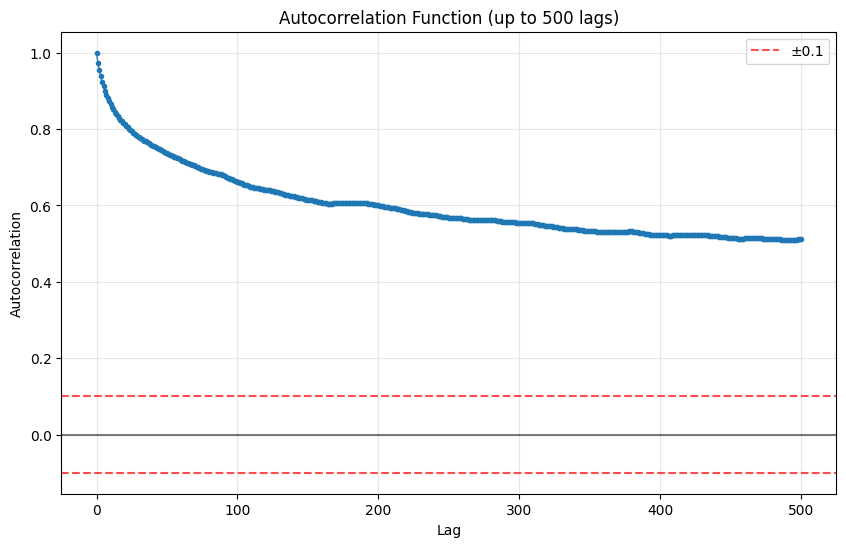


--- Run 3 ---
Sigma autocorrelation plot:


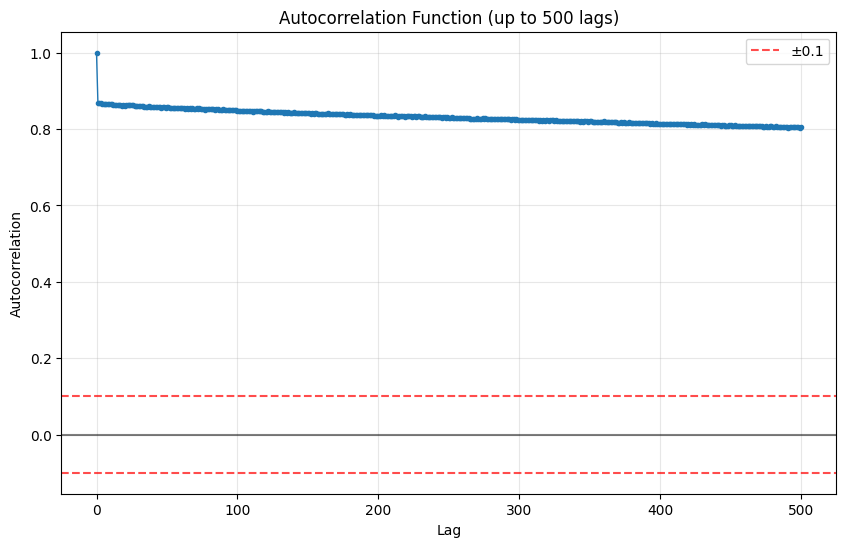

RMSE autocorrelation plot:


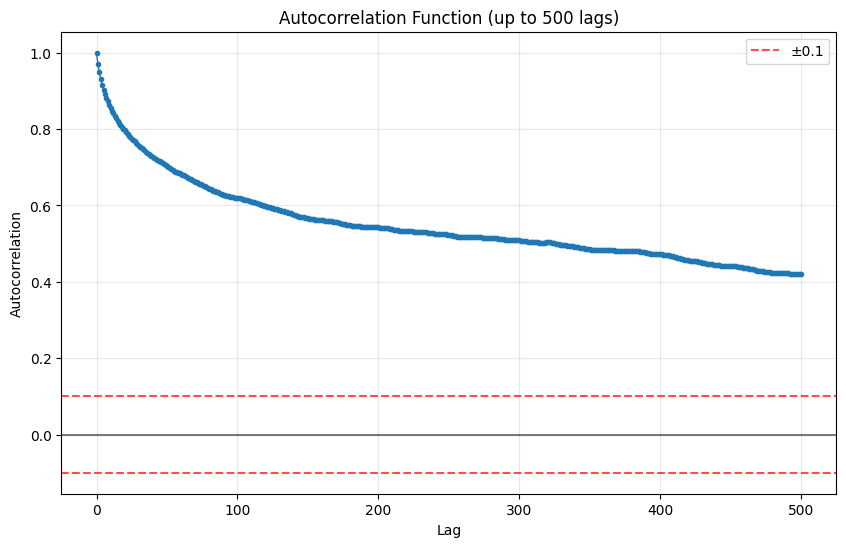


--- Run 4 ---
Sigma autocorrelation plot:


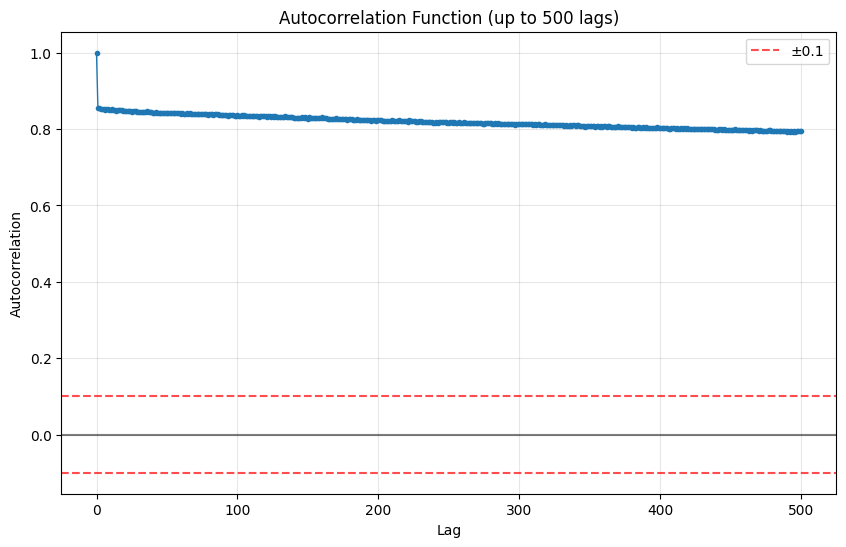

RMSE autocorrelation plot:


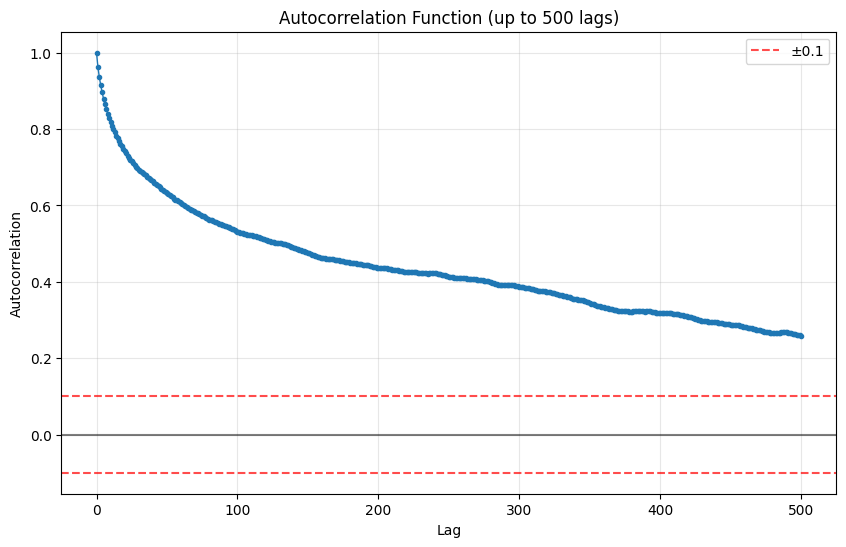

In [14]:
# Analyze each run's results
n_runs = 5

# Analyze Default BART results
print("=== Default BART Analysis ===")
for run_id in range(n_runs):
    print(f"\n--- Run {run_id} ---")
    
    # Load sigmas and rmses for this run
    sigmas = np.load(f'store/{notebook}_sigmas_default_run{run_id}.npy')
    rmses = np.load(f'store/{notebook}_rmses_default_run{run_id}.npy')

    print(f"Sigma autocorrelation plot:")
    plot_autocorrelation(sigmas[10000:], nlags=500)
    
    print(f"RMSE autocorrelation plot:")
    plot_autocorrelation(rmses[10000:], nlags=500)

## MTMH
### KPSS test

In [15]:
from diagnosis import segmented_kpss_test

=== MTMH BART Analysis ===

--- Run 0 ---
Sigma convergence analysis:


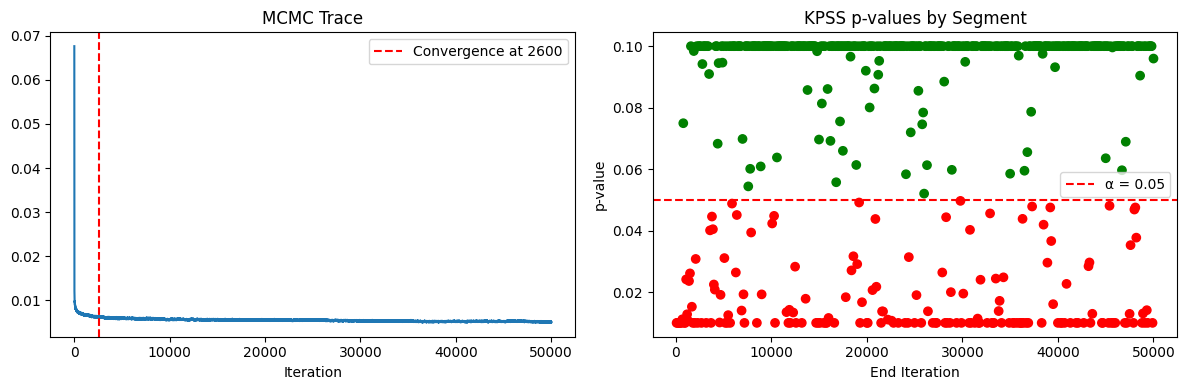

Chain converged: True
Convergence at iteration: 2600
Convergence rate: 65.60%

RMSE convergence analysis:


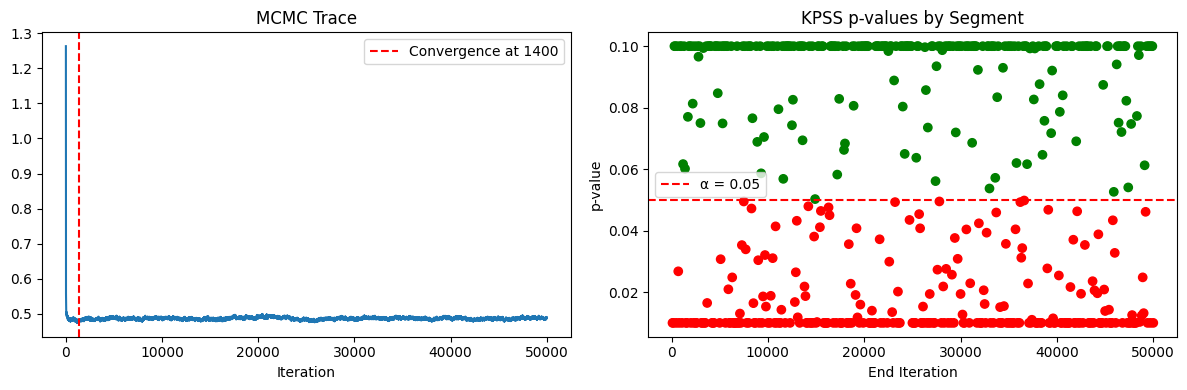

Chain converged: True
Convergence at iteration: 1400
Convergence rate: 47.60%

--- Run 1 ---
Sigma convergence analysis:


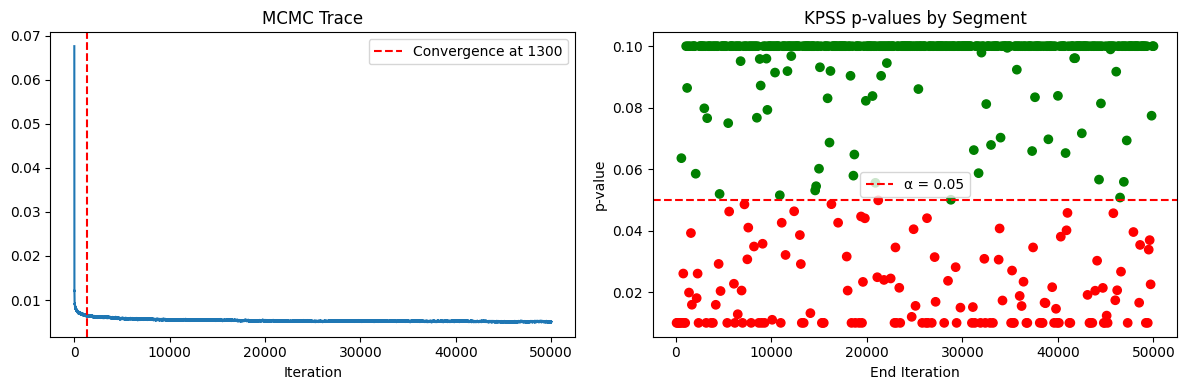

Chain converged: True
Convergence at iteration: 1300
Convergence rate: 71.00%

RMSE convergence analysis:


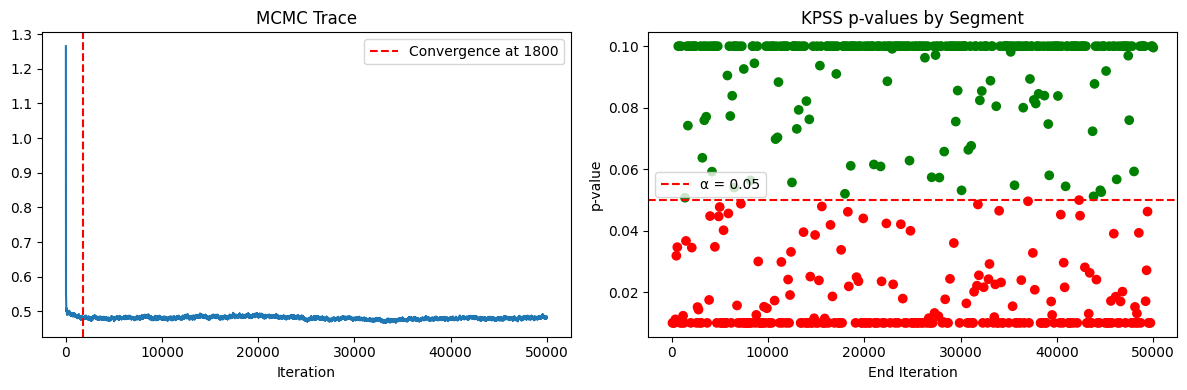

Chain converged: True
Convergence at iteration: 1800
Convergence rate: 52.40%

--- Run 2 ---
Sigma convergence analysis:


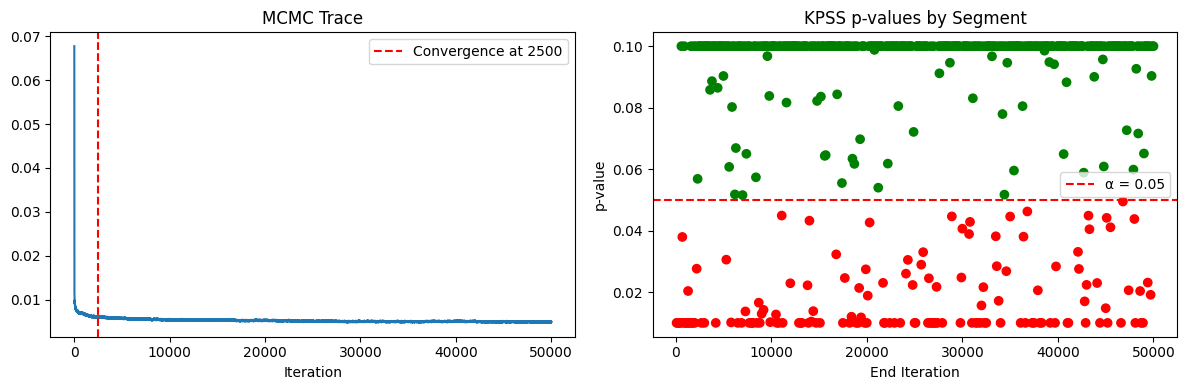

Chain converged: True
Convergence at iteration: 2500
Convergence rate: 71.00%

RMSE convergence analysis:


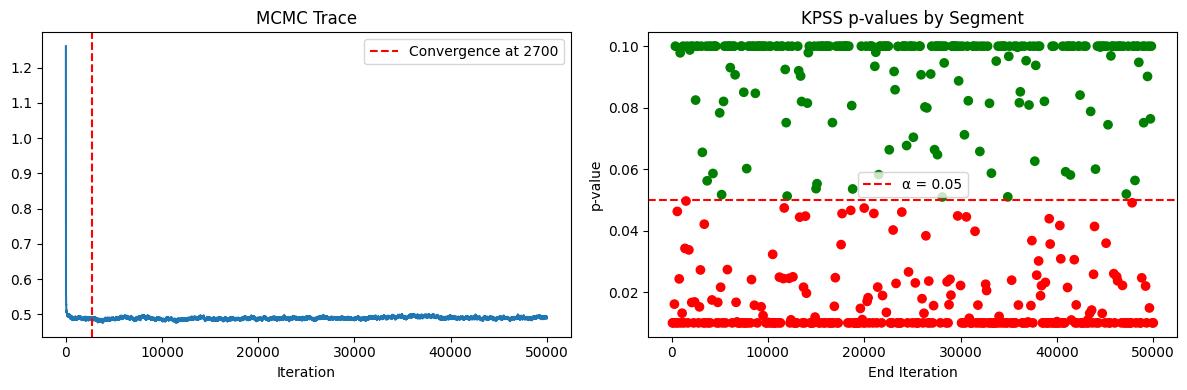

Chain converged: True
Convergence at iteration: 2700
Convergence rate: 46.00%

--- Run 3 ---
Sigma convergence analysis:


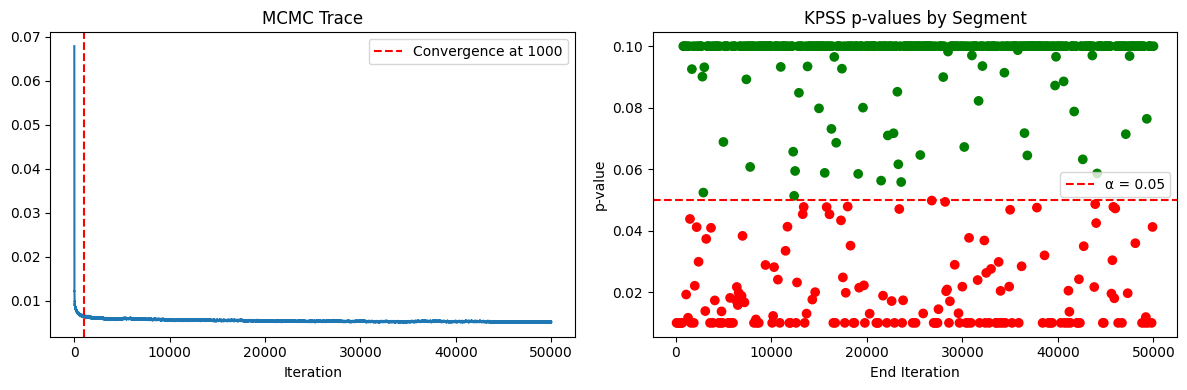

Chain converged: True
Convergence at iteration: 1000
Convergence rate: 67.40%

RMSE convergence analysis:


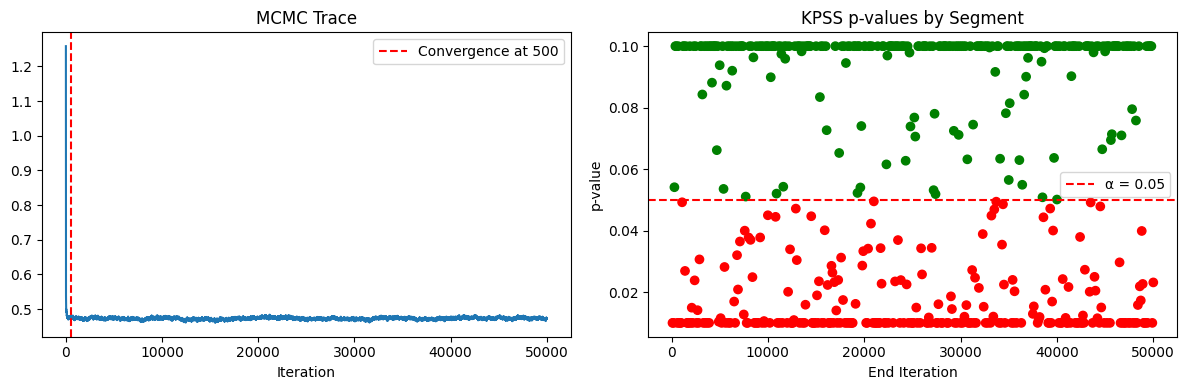

Chain converged: True
Convergence at iteration: 500
Convergence rate: 50.40%

--- Run 4 ---
Sigma convergence analysis:


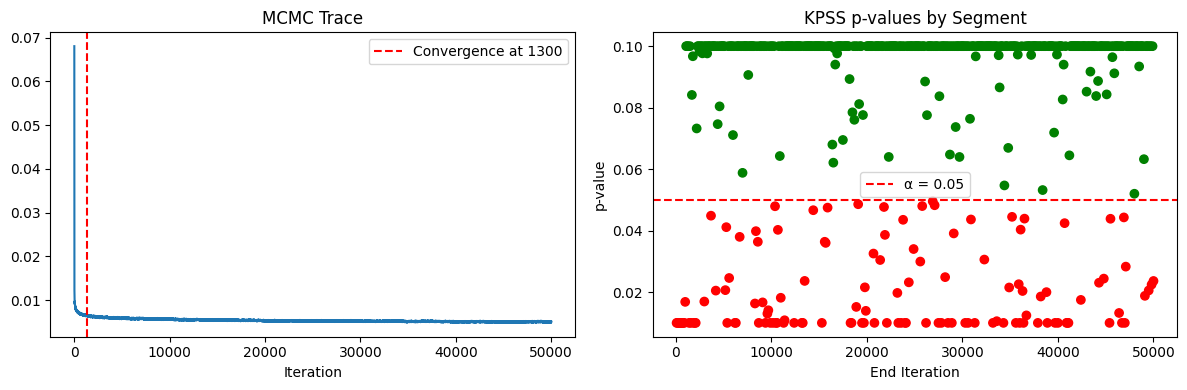

Chain converged: True
Convergence at iteration: 1300
Convergence rate: 74.80%

RMSE convergence analysis:


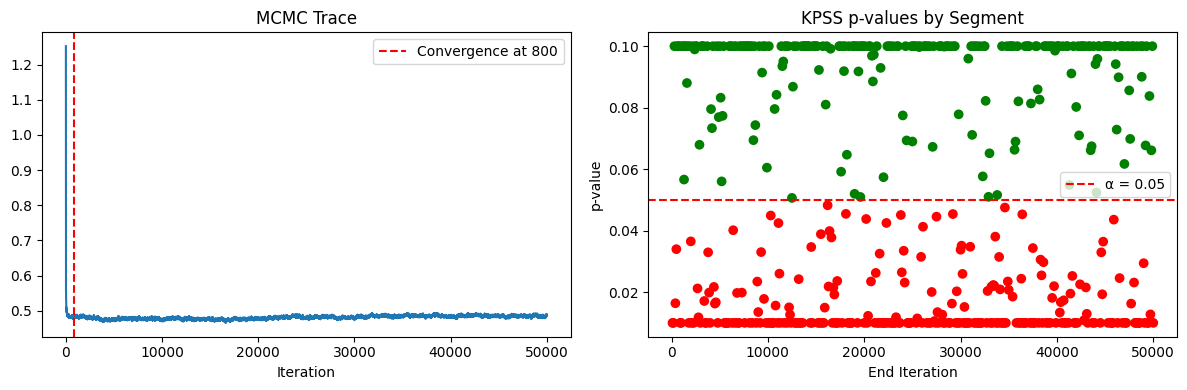

Chain converged: True
Convergence at iteration: 800
Convergence rate: 48.60%


In [16]:
# Analyze each run's results and collect statistics
n_runs = 5

# Collect convergence statistics
mtmh_sigma_convergence = []
mtmh_rmse_convergence = []
mtmh_sigma_rates = []
mtmh_rmse_rates = []

# Analyze MTMH BART results
print("=== MTMH BART Analysis ===")
for run_id in range(n_runs):
    print(f"\n--- Run {run_id} ---")
    
    # Load sigmas and rmses for this run
    sigmas = np.load(f'store/{notebook}_sigmas_mtmh_run{run_id}.npy')
    rmses = np.load(f'store/{notebook}_rmses_mtmh_run{run_id}.npy')

    print(f"Sigma convergence analysis:")
    convergence_result = segmented_kpss_test(sigmas, segment_length=100)
    print(f"Chain converged: {convergence_result['converged']}")
    if convergence_result['converged']:
        print(f"Convergence at iteration: {convergence_result['convergence_iteration']}")
        mtmh_sigma_convergence.append(convergence_result['convergence_iteration'])
    print(f"Convergence rate: {convergence_result['convergence_rate']:.2%}")
    mtmh_sigma_rates.append(convergence_result['convergence_rate'])

    print(f"\nRMSE convergence analysis:")
    convergence_result = segmented_kpss_test(rmses, segment_length=100)
    print(f"Chain converged: {convergence_result['converged']}")
    if convergence_result['converged']:
        print(f"Convergence at iteration: {convergence_result['convergence_iteration']}")
        mtmh_rmse_convergence.append(convergence_result['convergence_iteration'])
    print(f"Convergence rate: {convergence_result['convergence_rate']:.2%}")
    mtmh_rmse_rates.append(convergence_result['convergence_rate'])

In [17]:
# Print summary statistics for MTMH BART
print("\n=== MTMH BART Summary ===")
if mtmh_sigma_convergence:
    print(f"Sigma - Average convergence iteration: {np.mean(mtmh_sigma_convergence):.0f}")
else:
    print("Sigma - No convergence detected")
print(f"Sigma - Average convergence rate: {np.mean(mtmh_sigma_rates):.2%}")

if mtmh_rmse_convergence:
    print(f"RMSE - Average convergence iteration: {np.mean(mtmh_rmse_convergence):.0f}")
else:
    print("RMSE - No convergence detected")
print(f"RMSE - Average convergence rate: {np.mean(mtmh_rmse_rates):.2%}")


=== MTMH BART Summary ===
Sigma - Average convergence iteration: 1740
Sigma - Average convergence rate: 69.96%
RMSE - Average convergence iteration: 1440
RMSE - Average convergence rate: 49.00%


### ESS

In [18]:
# Add logging configuration before importing arviz
import logging
logging.getLogger('arviz.preview').setLevel(logging.WARNING)
import arviz as az

In [19]:
# Analyze each run's results
n_runs = 5

# Analyze MTMH BART results
print("=== MTMH BART Analysis ===")
for run_id in range(n_runs):
    print(f"\n--- Run {run_id} ---")
    
    # Load sigmas and rmses for this run
    sigmas = np.load(f'store/{notebook}_sigmas_mtmh_run{run_id}.npy')
    rmses = np.load(f'store/{notebook}_rmses_mtmh_run{run_id}.npy')

    print(f"Sigma ess value: {az.ess(sigmas[10000:].reshape(1, -1), relative=True).item():.6f}")
    print(f"RMSE ess value: {az.ess(rmses[10000:].reshape(1, -1), relative=True).item():.6f}")

=== MTMH BART Analysis ===

--- Run 0 ---
Sigma ess value: 0.000033
RMSE ess value: 0.000812

--- Run 1 ---
Sigma ess value: 0.000050
RMSE ess value: 0.000070

--- Run 2 ---
Sigma ess value: 0.000040
RMSE ess value: 0.000081

--- Run 3 ---
Sigma ess value: 0.000042
RMSE ess value: 0.000912

--- Run 4 ---
Sigma ess value: 0.000036
RMSE ess value: 0.000041


### Autocorrelation

In [20]:
from diagnosis import plot_autocorrelation

=== MTMH BART Analysis ===

--- Run 0 ---
Sigma autocorrelation plot:


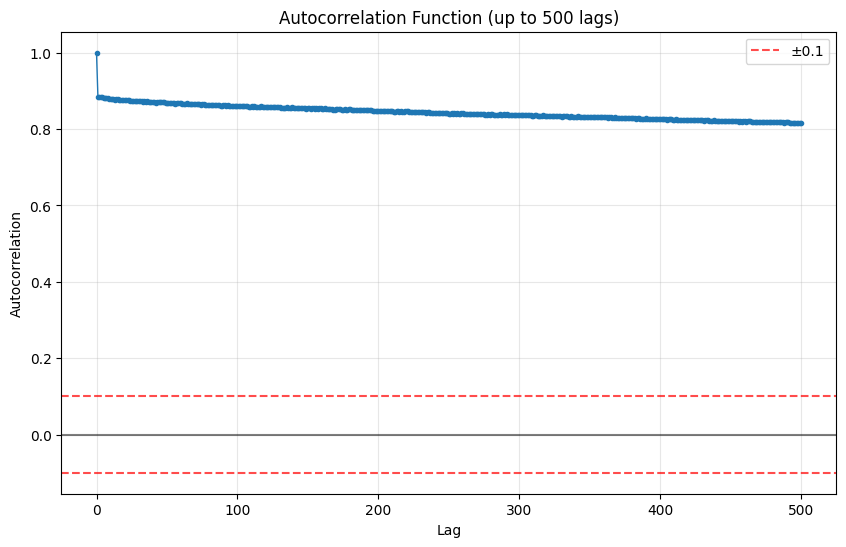

RMSE autocorrelation plot:


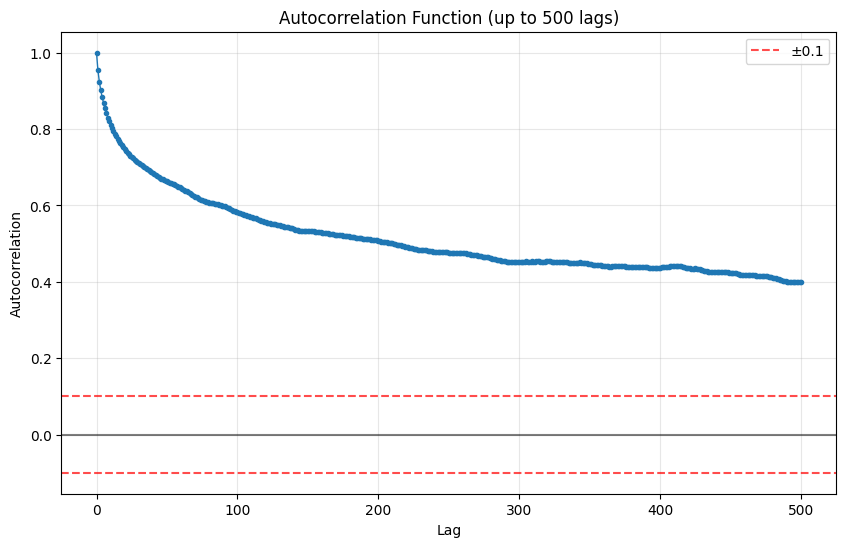


--- Run 1 ---
Sigma autocorrelation plot:


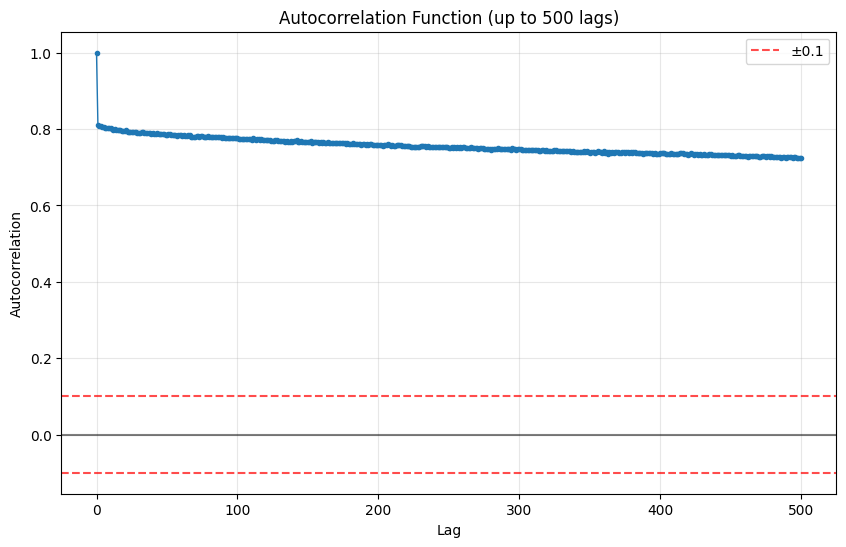

RMSE autocorrelation plot:


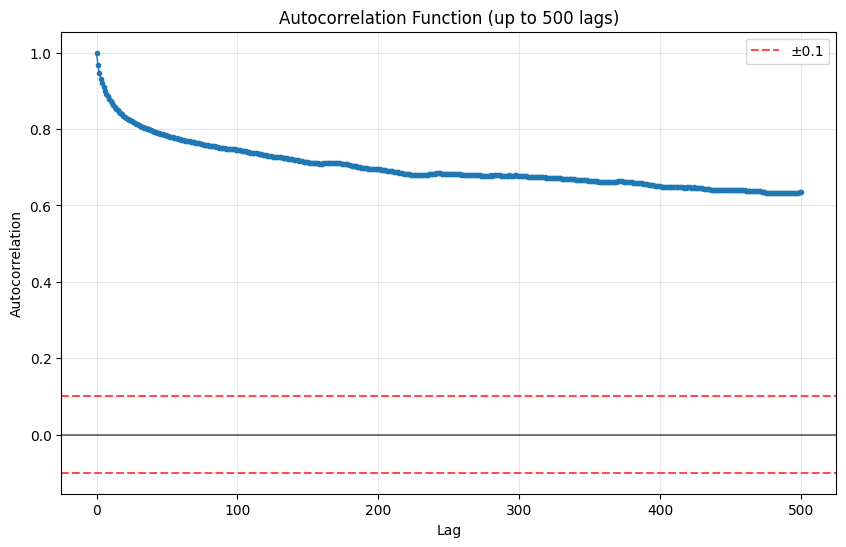


--- Run 2 ---
Sigma autocorrelation plot:


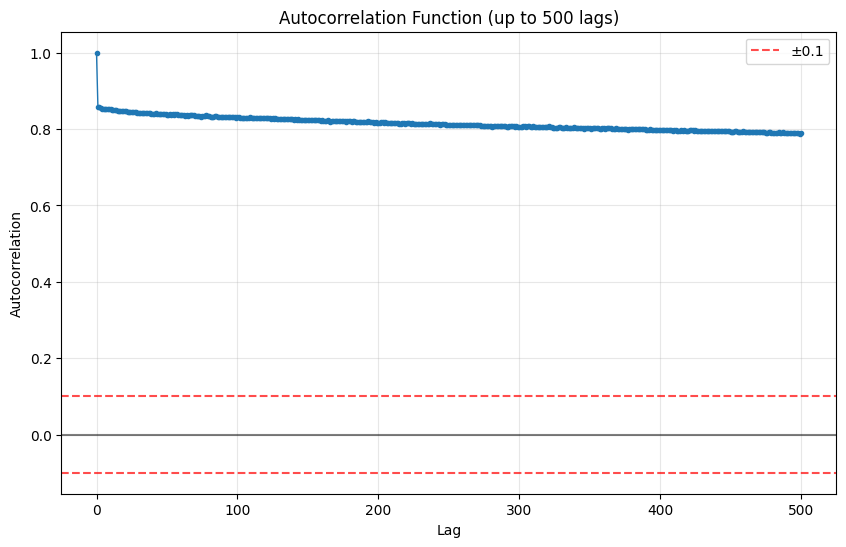

RMSE autocorrelation plot:


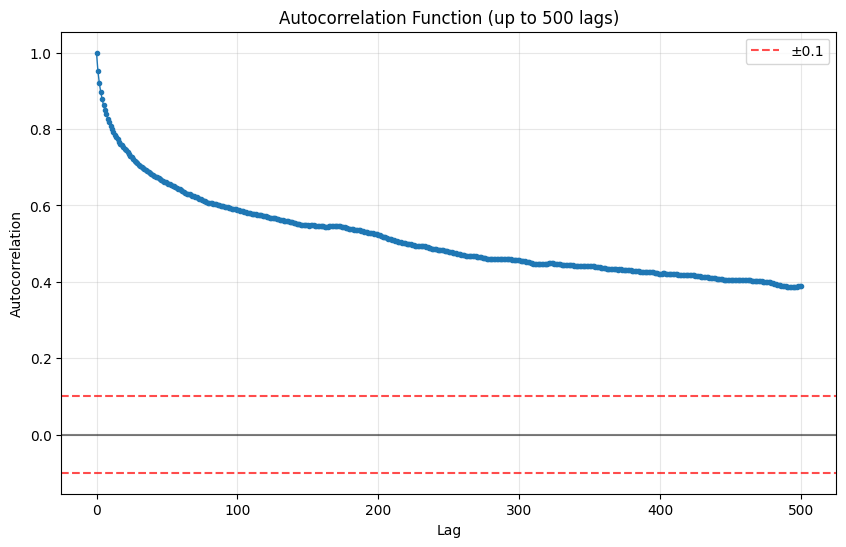


--- Run 3 ---
Sigma autocorrelation plot:


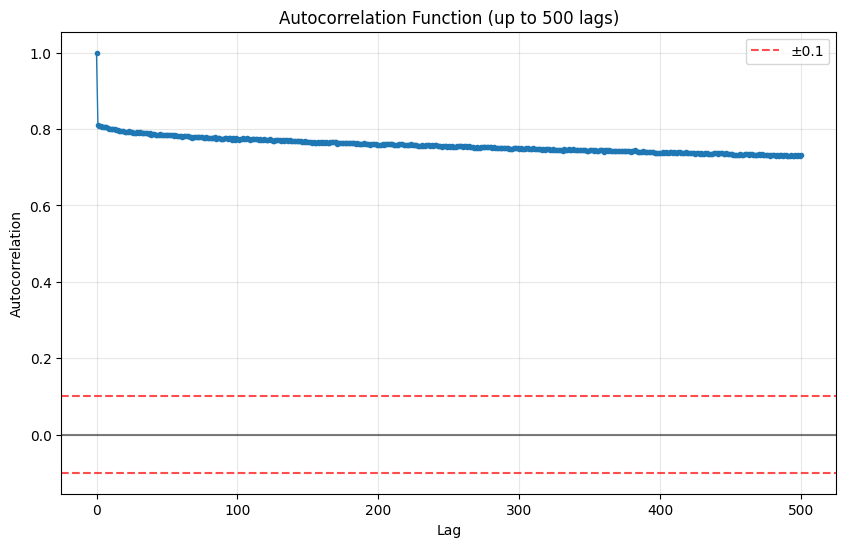

RMSE autocorrelation plot:


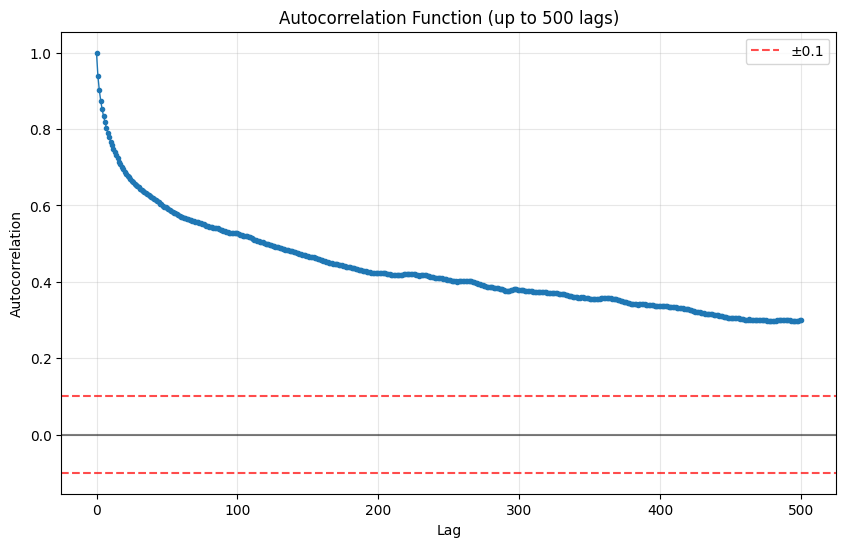


--- Run 4 ---
Sigma autocorrelation plot:


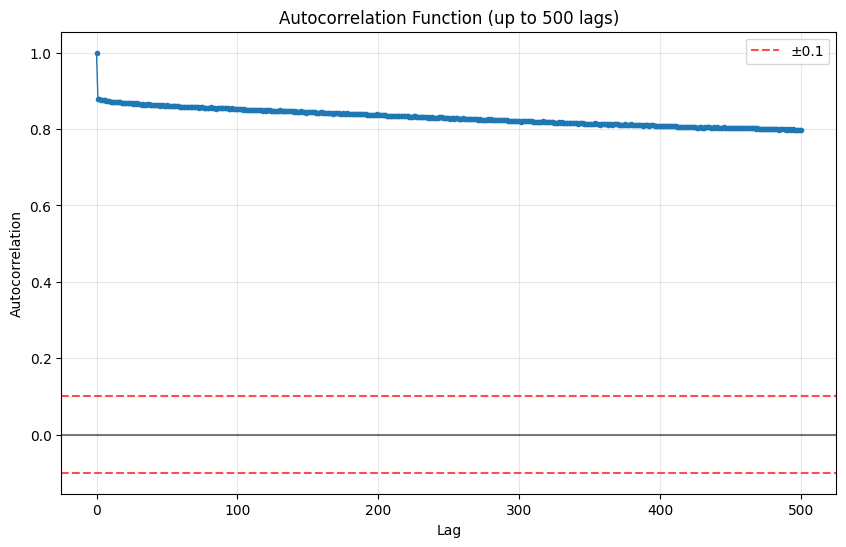

RMSE autocorrelation plot:


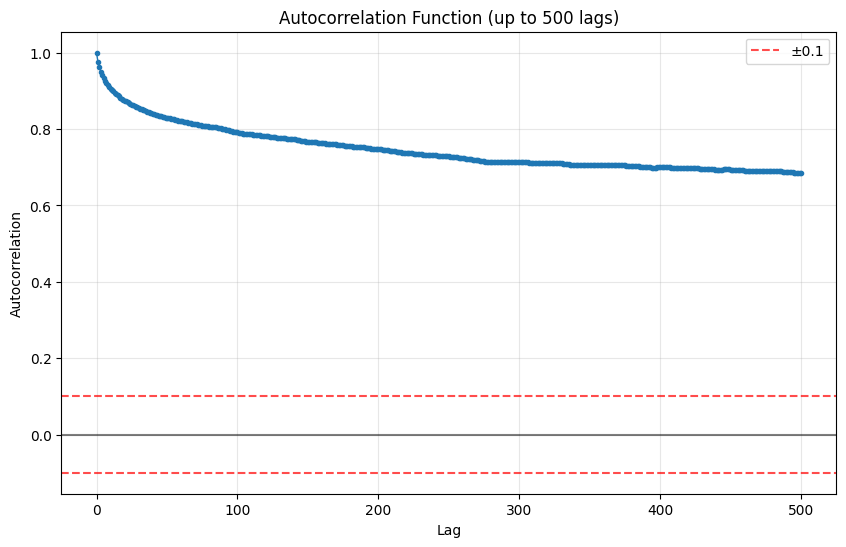

In [21]:
# Analyze each run's results
n_runs = 5

# Analyze MTMH BART results
print("=== MTMH BART Analysis ===")
for run_id in range(n_runs):
    print(f"\n--- Run {run_id} ---")
    
    # Load sigmas and rmses for this run
    sigmas = np.load(f'store/{notebook}_sigmas_mtmh_run{run_id}.npy')
    rmses = np.load(f'store/{notebook}_rmses_mtmh_run{run_id}.npy')

    print(f"Sigma autocorrelation plot:")
    plot_autocorrelation(sigmas[10000:], nlags=500)
    
    print(f"RMSE autocorrelation plot:")
    plot_autocorrelation(rmses[10000:], nlags=500)